### Generating Native-Guides for The FCN Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
from scipy.spatial.distance import cdist, pdist
from scipy import stats
from sklearn.neighbors import DistanceMetric
from tslearn.datasets import UCR_UEA_datasets
from tslearn.neighbors import NearestNeighbors, KNeighborsTimeSeries
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, GlobalAveragePooling1D, BatchNormalization, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import function
from sklearn.neighbors import LocalOutlierFactor
from tslearn.utils import to_sklearn_dataset
from tensorflow import keras
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
print(tf.__version__)


2.4.1


In [2]:
dataset = 'ecg200'

In [3]:
def ucr_data_loader(dataset):
    
    X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(dataset)
    
    return X_train, y_train, X_test, y_test

In [4]:
def label_encoder(training_labels, testing_labels):
    le = preprocessing.LabelEncoder()
    le.fit(np.concatenate((training_labels, testing_labels), axis=0))
    y_train = le.transform(training_labels)
    y_test = le.transform(testing_labels)    
    return y_train, y_test
    
    

In [5]:
def native_guide_retrieval(query, predicted_label, distance, n_neighbors):

    df = pd.DataFrame(y_train, columns = ['label'])
    df.index.name = 'index'
    df[df['label'] == 1].index.values, df[df['label'] != 1].index.values
    
    ts_length = X_train.shape[1]
    

    knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric = distance)
    
    knn.fit(X_train[list(df[df['label'] != predicted_label].index.values)])
    
    dist,ind = knn.kneighbors(query.reshape(1,ts_length), return_distance=True)
    return dist[0], df[df['label'] != predicted_label].index[ind[0][:]]

### Native Guide CFS

In [6]:
dataset = 'ecg200'
model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model.hdf5')

X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
y_train, y_test = label_encoder(y_train, y_test)


y_pred = np.argmax(model.predict(X_test), axis=1)

nuns = []
for instance in range(len(X_test)):
    nuns.append(native_guide_retrieval(X_test[instance], y_pred[instance], 'euclidean', 1)[1][0])
nuns = np.array(nuns)

In [7]:
def findSubarray(a, k): #used to find the maximum contigious subarray of length k in the explanation weight vector
    
    n = len(a)
    
    vec=[] 

    # Iterate to find all the sub-arrays 
    for i in range(n-k+1): 
        temp=[] 

        # Store the sub-array elements in the array 
        for j in range(i,i+k): 
            temp.append(a[j]) 

        # Push the vector in the container 
        vec.append(temp) 

    sum_arr = []
    for v in vec:
        sum_arr.append(np.sum(v))

    return (vec[np.argmax(sum_arr)])

In [8]:
training_weights = np.load('../Class_Activation_Mapping/' +str(dataset) +'_cam_train_weights.npy')
testing_weights = np.load('../Class_Activation_Mapping/' +str(dataset) +'_cam_test_weights.npy')

In [9]:
def counterfactual_generator_swap(instance, nun, subarray_length):
    
    most_influencial_array=findSubarray((training_weights[nun]), subarray_length)
    
    starting_point = np.where(training_weights[nun]==most_influencial_array[0])[0][0]
    
    X_example = np.concatenate((X_test[instance][:starting_point], (X_train[nun][starting_point:subarray_length+starting_point]), X_test[instance][subarray_length+starting_point:]))
    
    prob_target = model.predict(X_example.reshape(1,-1,1))[0][y_pred[instance]]
    
    while prob_target > 0.5:
        
        subarray_length +=1
        
        most_influencial_array=findSubarray((training_weights[nun]), subarray_length)
        starting_point = np.where(training_weights[nun]==most_influencial_array[0])[0][0]
        X_example = np.concatenate((X_test[instance][:starting_point], (X_train[nun][starting_point:subarray_length+starting_point]), X_test[instance][subarray_length+starting_point:]))
        prob_target = model.predict(X_example.reshape(1,-1,1))[0][y_pred[instance]]
        
    return X_example

In [10]:
test_instances = np.array(range(len(X_test)))
test_instances

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

### For All Datasets

In [11]:
for dataset in ['ecg200', 'chinatown', 'gunpoint', 'coffee', 'CBF']:
    
    model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model.hdf5')
    training_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_train_weights.npy')
    testing_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_test_weights.npy')

    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)


    y_pred = np.argmax(model.predict(X_test), axis=1)

    nuns = []
    for instance in range(len(X_test)):
        nuns.append(native_guide_retrieval(X_test[instance], y_pred[instance], 'euclidean', 1)[1][0])
    
    nuns = np.array(nuns)
    test_instances = np.array(range(len(X_test)))
    
    
    cf_cam_swap = []
    
    for test_instance, nun in zip(test_instances, nuns):
        cf_cam_swap.append(counterfactual_generator_swap(test_instance,nun,1))

    np.save(str(dataset)+'_native_guide_isw.npy', np.array(cf_cam_swap))

### Looking at Produced Counterfactuals and Diversity

For diverse solutions we can use different NUNs (e.g the 3rd NUN) to guide the counterfactual generation process.

#### CBF

In [12]:
for dataset in ['CBF']:
    
    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    cam_swap_cf = np.load(str(dataset)+'_native_guide_isw.npy')
    model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model.hdf5')
    training_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_train_weights.npy')
    testing_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_test_weights.npy')
    y_pred = np.argmax(model.predict(X_test), axis=1)    

In [13]:
native_guide_retrieval(X_test[0], y_pred[0], 'euclidean',10)

(array([ 9.82496518, 11.51063329, 11.64218176, 11.88514247, 11.98183798,
        11.9877963 , 12.31450316, 12.32006369, 12.40384597, 12.70900847]),
 Int64Index([2, 24, 15, 0, 27, 9, 28, 25, 1, 29], dtype='int64', name='index'))

In [14]:
np.argmax(model.predict(counterfactual_generator_swap(0, 2,1).reshape(1,-1,1)))
np.argmax(model.predict(counterfactual_generator_swap(0, 9,1).reshape(1,-1,1)))

0

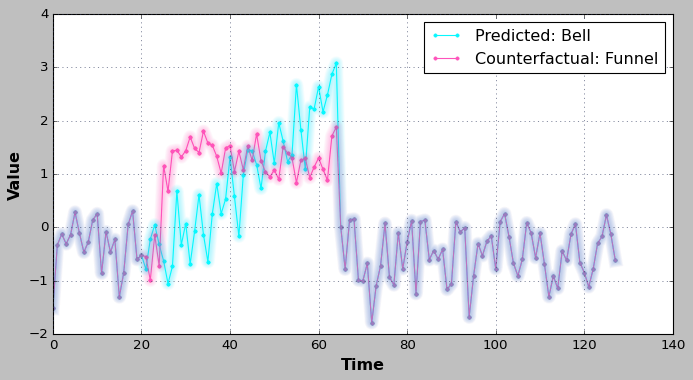

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic")
colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]
df = pd.DataFrame({'Predicted: Bell': list(X_test[0].flatten()),
                   'Counterfactual: Funnel': list(cam_swap_cf[0].flatten())})
fig, ax = plt.subplots(figsize=(10,5))
df.plot(marker='.', color=colors, ax=ax)
# Redraw the data with low alpha and slighty increased linewidth:
n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df.plot(marker='.',
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)

ax.grid(color='#2A3459')
plt.xlabel('Time', fontweight = 'bold', fontsize='large')
plt.ylabel('Value', fontweight = 'bold', fontsize='large')
#plt.savefig('../Images/Initial_Example_Neon.pdf')
plt.show()

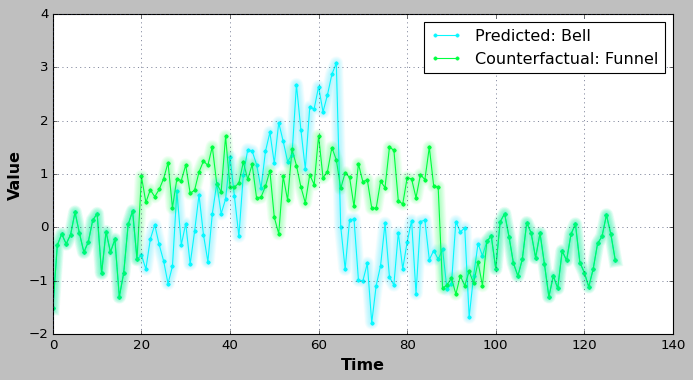

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic")
colors = [
    '#08F7FE',  # teal/cyan
#    '#FE53BB',  # pink
#    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]
df = pd.DataFrame({'Predicted: Bell': list(X_test[0].flatten()),
                   'Counterfactual: Funnel': list(counterfactual_generator_swap(0, 9,1).flatten())})
fig, ax = plt.subplots(figsize=(10,5))
df.plot(marker='.', color=colors, ax=ax)
# Redraw the data with low alpha and slighty increased linewidth:
n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df.plot(marker='.',
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)
    
ax.grid(color='#2A3459')
plt.xlabel('Time', fontweight = 'bold', fontsize='large')
plt.ylabel('Value', fontweight = 'bold', fontsize='large')
#plt.savefig('../Images/Initial_Example_Neon.pdf')
plt.show()

#### Coffee

In [17]:
for dataset in ['coffee']:
    
    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    cam_swap_cf = np.load(str(dataset)+'_native_guide_isw.npy')
    model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model.hdf5')
    training_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_train_weights.npy')
    testing_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_test_weights.npy')
    y_pred = np.argmax(model.predict(X_test), axis=1)   

In [18]:
np.where(y_pred==0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int64),)

In [19]:
native_guide_retrieval(X_test[10], y_pred[0], 'euclidean',14)

(array([1.81011016, 1.84947036, 1.96159482, 1.96635242, 1.97374239,
        1.97886154, 2.13515831, 2.14519135, 2.1594211 , 2.17134443,
        2.32487309, 2.50543722, 2.6169788 , 3.16354579]),
 Int64Index([16, 25, 23, 27, 14, 26, 19, 18, 15, 17, 21, 24, 22, 20], dtype='int64', name='index'))

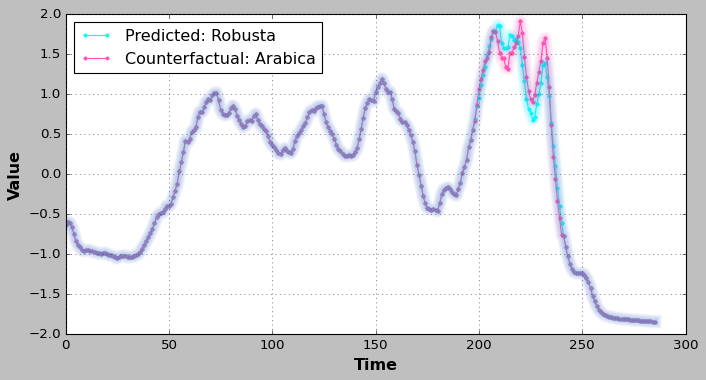

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic")
colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]
df = pd.DataFrame({'Predicted: Robusta': list(X_test[10].flatten()),
                   'Counterfactual: Arabica': list(cam_swap_cf[10].flatten())})
fig, ax = plt.subplots(figsize=(10,5))
df.plot(marker='.', color=colors, ax=ax)
# Redraw the data with low alpha and slighty increased linewidth:
n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df.plot(marker='.',
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)
    
ax.grid(color='#2A3459')
plt.xlabel('Time', fontweight = 'bold', fontsize='large')
plt.ylabel('Value', fontweight = 'bold', fontsize='large')
plt.savefig('../Images/Coffee_Example.pdf')
plt.show()

#### ECG200 (Diversity)

In [21]:
for dataset in ['ecg200']:
    
    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    cam_swap_cf = np.load(str(dataset)+'_native_guide_isw.npy')
    model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model.hdf5')
    training_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_train_weights.npy')
    testing_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_test_weights.npy')
    y_pred = np.argmax(model.predict(X_test), axis=1)    

In [22]:
np.where(y_pred==0)

(array([ 2,  6,  9, 10, 12, 13, 14, 18, 20, 26, 28, 32, 33, 35, 38, 39, 41,
        42, 51, 52, 53, 57, 59, 60, 63, 64, 65, 75, 84, 86, 87, 91, 92, 97,
        98], dtype=int64),)

In [23]:
native_guide_retrieval(X_test[65], y_pred[65], 'euclidean',10)

(array([4.59697954, 5.36185596, 5.53132266, 5.71314263, 6.1420083 ,
        6.27087678, 6.36499079, 6.79639667, 7.51418388, 8.24182907]),
 Int64Index([95, 62, 41, 40, 79, 70, 11, 38, 10, 94], dtype='int64', name='index'))

In [24]:
y_pred[75]

0

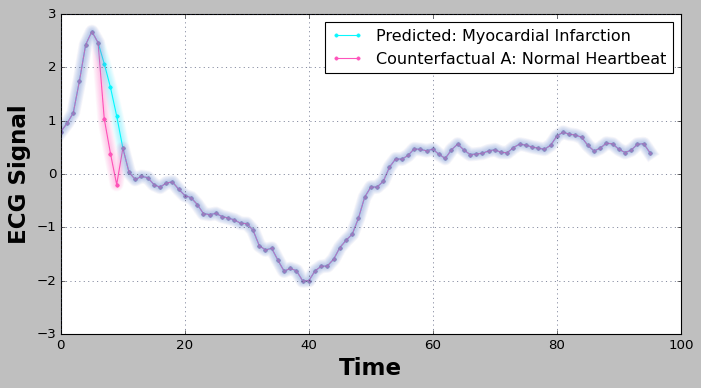

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic")
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0'  # very light grey
#for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
#    plt.rcParams[param] = '#212946'  # bluish dark grey
colors = ['#08F7FE',  # teal/cyan
    '#FE53BB', # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]
df = pd.DataFrame({'Predicted: Myocardial Infarction': list(X_test[9].flatten()),
                   'Counterfactual A: Normal Heartbeat': list(cam_swap_cf[9].flatten())})
fig, ax = plt.subplots(figsize=(10,5))
df.plot(marker='.', color=colors, ax=ax)
# Redraw the data with low alpha and slighty increased linewidth:
n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df.plot(marker='.',
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)

ax.grid(color='#2A3459')
plt.xlabel('Time', fontweight = 'bold', fontsize='xx-large')
plt.ylabel('ECG Signal', fontweight = 'bold', fontsize='xx-large')
plt.savefig('../Images/Diverse_1.pdf')
plt.show()

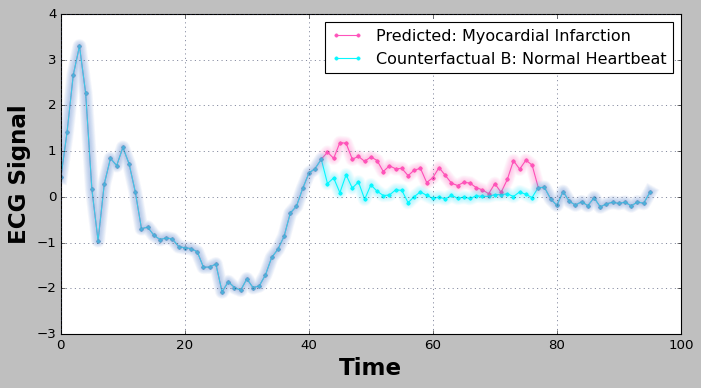

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic")
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0'  # very light grey

colors = [
    '#FE53BB',  # pink
    '#08F7FE',  # teal/cyan
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]
df = pd.DataFrame({'Predicted: Myocardial Infarction': list(X_test[0].flatten()),
                   'Counterfactual B: Normal Heartbeat': list(counterfactual_generator_swap(0, 61,1).flatten())})
fig, ax = plt.subplots(figsize=(10,5))
df.plot(marker='.', color=colors, ax=ax)
# Redraw the data with low alpha and slighty increased linewidth:
n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df.plot(marker='.',
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)

ax.grid(color='#2A3459')
plt.xlabel('Time', fontweight = 'bold', fontsize='xx-large')
plt.ylabel('ECG Signal', fontweight = 'bold', fontsize='xx-large')
plt.savefig('../Images/Diverse_2.pdf')
plt.show()

In [27]:
model.predict(X_test[1].reshape(1,-1,1))

array([[3.9913147e-08, 1.0000000e+00]], dtype=float32)

In [28]:
model.predict(cam_swap_cf[1].reshape(1,-1,1))

array([[0.5152156 , 0.48478442]], dtype=float32)